# mmFace + InsightFace2D Hybrid Model

## Build and Load Dataset

Real Dataset:
- 21 Subjects, 15 Experiments
  * Total 250 data frames -> Shuffle -> Take first 15 frames and split
  * Total 10 RGB embeddings -> Filter undetected -> Shuffle and Fill 15 frames and split

`15*15*21 = 4725 Data Points`

Fake Dataset:
- 21 Subjects, 3 Experiments
  * Total 74 ARD frames -> Shuffle -> Split
  * Total 10 RGB embeddings -> Filter undetected -> Shuffle and Fill 74 frames and split

`74*3*21 = 4662 Data Points`

`NB: If no RGB embedding for an subject experiment, need to completely remove that`

In [2]:
from hybrid_dataset import load_dataset, load_dataset_subject, load_aug_dataset, load_aug_dataset_subject, get_rgb_emb_aug, get_ard_aug
from tqdm import tqdm
import numpy as np
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device, '\n')

RAW_PATH = os.path.relpath("../../Soli/soli_realsense/data")
num_subjects = 21
seed = 69

torch.cuda.empty_cache()
# train, validation, test = load_dataset(RAW_PATH, num_subjects, device=device)
# train, validation, test = load_dataset_subject(RAW_PATH, num_subjects, train_split=15/21, test_split=3/21, device=device)
# train, validation, test = load_aug_dataset(RAW_PATH, num_subjects, device=device)
# TODO: EXPERIMENT WITH SEED FOR DIFFERENT UNSEEN SUBJECTS
train, test, test_idx = load_aug_dataset_subject(RAW_PATH, num_subjects, batch_size=128, device=device)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_use_max_workspace': '1', 'cudnn_conv1d_pad_to_nc1d': '0', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'enable_skip_layer_norm_strict_mode': '0'}, 'CPUExecutionProvider': {}}
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo',

## Model Creation and Loading

In [5]:
from neural_nets import MMFaceHybrid
from utils import load_model, load_history
from torch import nn

num_epochs = 6
learning_rate = 0.01

lambda1, lambda2 = 1, 1

model = MMFaceHybrid(num_subjects).to(device)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = f"mmFace-hybrid-AUGMENTED-ZERO-SHOT.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]}\n\tValidation Accuracy: {val_acc}")

mmFace-hybrid-AUGMENTED-ZERO-SHOT.pt
	Epoch: 10
	Loss: 0.0125
	Train Accuracy: (99.96999099729919, 99.9849954986496)
	Validation Accuracy: []


## Training

In [3]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc_s, running_acc_l, total_s, total_l = 0., 0., 0., 0., 0.

    for radar, rgb_emb, labels_s, labels_l in tqdm(train):
        # Forward Pass
        # TODO: ZERO OUT RGB_EMB
        out1, out2 = model(radar, rgb_emb)
        _, preds_s = torch.max(out1.data, 1)
        _, preds_l = torch.max(out2.data, 1)
        loss1 = criterion(out1, labels_s)
        loss2 = criterion(out2, labels_l)
        loss = lambda1*loss1 + lambda2*loss2

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total_s += labels_s.size(0)
        total_l += labels_l.size(0)
        running_acc_s += (preds_s == labels_s).sum().item()
        running_acc_l += (preds_l == labels_l).sum().item()

        del radar, rgb_emb, labels_s, labels_l, out1, out2
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc_s = 100*running_acc_s/total_s
    avg_train_acc_l = 100*running_acc_l/total_l
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy (Subjects): {avg_train_acc_s:.4f}%")
    print(f"\tTrain Accuracy (Liveness): {avg_train_acc_l:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [(avg_train_acc_s, avg_train_acc_l)],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    # model.eval()
    # with torch.no_grad():
    #     correct_s, correct_l, total_s, total_l = 0., 0., 0., 0.
    #     for radar, rgb_emb, labels_s, labels_l in validation:
    #         out1, out2 = model(radar, rgb_emb)
    #         _, preds_s = torch.max(out1.data, 1)
    #         _, preds_l = torch.max(out2.data, 1)
    #         total_s += labels_s.size(0)
    #         total_l += labels_l.size(0)
    #         correct_s += (preds_s == labels_s).sum().item()
    #         correct_l += (preds_l == labels_l).sum().item()
    #         del radar, rgb_emb, labels_s, labels_l, out1, out2
        
    #     avg_val_acc_s = 100*correct_s/total_s
    #     avg_val_acc_l = 100*correct_l/total_l
    #     print(f"\tValidation Accuracy (Subject): {avg_val_acc_s:.4f}%")
    #     print(f"\tValidation Accuracy (Liveness): {avg_val_acc_l:.4f}%")

    # model_checkpoint = torch.load(f"models/{model_name}")
    # model_checkpoint["val_acc"].append((avg_val_acc_s, avg_val_acc_l))
    # torch.save(model_checkpoint, f"models/{model_name}")


Epoch [0/9]:


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:03<00:00, 42.50it/s]


	Average Train Loss: 2.5455
	Train Accuracy (Subjects): 32.4097%
	Train Accuracy (Liveness): 98.2495%

Epoch [1/9]:


100%|██████████| 157/157 [00:03<00:00, 52.22it/s]


	Average Train Loss: 1.3508
	Train Accuracy (Subjects): 75.1826%
	Train Accuracy (Liveness): 99.1397%

Epoch [2/9]:


100%|██████████| 157/157 [00:02<00:00, 53.05it/s]


	Average Train Loss: 0.4871
	Train Accuracy (Subjects): 88.1014%
	Train Accuracy (Liveness): 99.3998%

Epoch [3/9]:


100%|██████████| 157/157 [00:02<00:00, 52.88it/s]


	Average Train Loss: 0.3110
	Train Accuracy (Subjects): 92.4627%
	Train Accuracy (Liveness): 99.5449%

Epoch [4/9]:


100%|██████████| 157/157 [00:03<00:00, 50.34it/s]


	Average Train Loss: 0.2226
	Train Accuracy (Subjects): 94.5834%
	Train Accuracy (Liveness): 99.7299%

Epoch [5/9]:


100%|██████████| 157/157 [00:02<00:00, 52.52it/s]


	Average Train Loss: 0.1541
	Train Accuracy (Subjects): 96.1939%
	Train Accuracy (Liveness): 99.7149%

Epoch [6/9]:


100%|██████████| 157/157 [00:02<00:00, 52.72it/s]


	Average Train Loss: 0.1006
	Train Accuracy (Subjects): 97.6743%
	Train Accuracy (Liveness): 99.9400%

Epoch [7/9]:


100%|██████████| 157/157 [00:02<00:00, 52.70it/s]


	Average Train Loss: 0.0665
	Train Accuracy (Subjects): 98.6096%
	Train Accuracy (Liveness): 99.9650%

Epoch [8/9]:


100%|██████████| 157/157 [00:03<00:00, 51.84it/s]


	Average Train Loss: 0.0272
	Train Accuracy (Subjects): 99.7149%
	Train Accuracy (Liveness): 99.9850%

Epoch [9/9]:


100%|██████████| 157/157 [00:03<00:00, 48.15it/s]

	Average Train Loss: 0.0125
	Train Accuracy (Subjects): 99.9700%
	Train Accuracy (Liveness): 99.9850%


## Testing

In [8]:
preds_subject, preds_liveness = [], []
true_subject, true_liveness = [], []

model.eval()
with torch.no_grad():
    correct_s, correct_l, total_s, total_l = 0., 0., 0., 0.
    for radar, rgb_emb, labels_s, labels_l in test:
        out1, out2 = model(radar, rgb_emb)
        _, preds_s = torch.max(out1.data, 1)
        _, preds_l = torch.max(out2.data, 1)
        total_s += labels_s.size(0)
        total_l += labels_l.size(0)
        correct_s += (preds_s == labels_s).sum().item()
        correct_l += (preds_l == labels_l).sum().item()

        preds_subject.extend(preds_s.cpu().numpy())
        preds_liveness.extend(preds_l.cpu().numpy())
        true_subject.extend(labels_s.data.cpu().numpy())
        true_liveness.extend(labels_l.data.cpu().numpy())
        del radar, rgb_emb, labels_s, labels_l, out1, out2
    
    print(f"Test Accuracy (Subject): {100*correct_s/total_s:.4f}%")
    print(f"Test Accuracy (Liveness): {100*correct_l/total_l:.4f}%")

Test Accuracy (Subject): 96.1749%
Test Accuracy (Liveness): 99.6243%


### Zero-Shot Testing

In [6]:
test_subjects = [i if i < num_subjects else int(f"9{(i-num_subjects)}") for i in test_idx]
print(test_subjects)

# Gather raw reference data (Taking frame 3 of ARD and RGB embedding of 0\deg,RLC,NO)
# TODO: EXPERIMENT WITH THE FRAME NUMBER AND SEED FOR DIFFERENT SUBJECTS
f = 3
references_raw = [(torch.tensor(get_ard_aug(RAW_PATH, sub, 0, 250, "none")[f], device=device).unsqueeze(0), 
                   torch.tensor(get_rgb_emb_aug(RAW_PATH, sub, 0, "none", set())[f], device=device, dtype=torch.float32).unsqueeze(0)) for sub in tqdm(test_subjects)]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.eval()
# Hook to get last layer feature embeddings
model.fc_hybrid1.register_forward_hook(get_activation("fc_hybrid1"))

reference_embs = np.zeros((len(references_raw), 64))
unseen_embeddings, true_labels_s, true_labels_l = [], [], []

with torch.no_grad():
    for i, raw_inputs in enumerate(references_raw):
        _ = model(*raw_inputs)
        reference_embs[i] = activation["fc_hybrid1"].detach().cpu().numpy()

    for radar, rgb_emb, subjects, liveness in test:
        _ = model(radar, rgb_emb)
        unseen_embeddings.append(activation["fc_hybrid1"].detach().cpu().numpy())
        true_labels_s.append(subjects.detach().cpu().numpy())
        true_labels_l.append(liveness.detach().cpu().numpy())


ref_labels_s = [idx if idx < num_subjects else idx-num_subjects for idx in test_idx]
ref_labels_l = [0 if idx < num_subjects else 1 for idx in test_idx]

unseen_embeddings = np.concatenate(unseen_embeddings)
true_labels_s = np.concatenate(true_labels_s)
true_labels_l = np.concatenate(true_labels_l)

[20, 2, 5, 15, 920, 92, 95, 915]


100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


In [75]:
from sklearn.metrics import confusion_matrix

def cos_sim(x, Y):
    return x @ Y.T / (np.linalg.norm(x)*np.linalg.norm(Y, axis=1))

def search_flatten(reference_embs, unseen_embeddings, labels1, labels2, min_t=0.5, max_t=0.999):
    preds = []
    for emb in unseen_embeddings:
        scores = cos_sim(emb, reference_embs)
        scores = np.clip(scores, 0., max_t)

        idx = np.argmax(scores)
        if scores[idx] > min_t:
            preds.append((labels1[idx], labels2[idx]))
        else:
            preds.append((None, None))
    
    return preds

def evaluate(true_labels, pred_labels, labels):
    coverage = np.mean([n is not None for n in pred_labels]) * 100.

    is_corrects = [t == p for t, p in zip(true_labels, pred_labels) if p]
    if not is_corrects:
        is_corrects.append(False)

    accuracy = np.mean(is_corrects) * 100.

    true_labels = np.array(true_labels, dtype=np.int32)
    pred_labels_norm = np.array(pred_labels)
    pred_labels_norm[np.where(pred_labels_norm == None)[0]] = -1
    pred_labels_norm = np.array(pred_labels_norm, dtype=np.int32)

    cfm = confusion_matrix(true_labels, pred_labels_norm, labels=labels)

    return accuracy, coverage, cfm

preds_s, preds_l = list(zip(*search_flatten(reference_embs, unseen_embeddings, ref_labels_s, ref_labels_l)))

test_labels_s = sorted(ref_labels_s[:len(ref_labels_s)//2]) + [-1]
test_labels_l = [0, 1, -1]

acc_subject, cov_subject, cfm_subject = evaluate(true_labels_s, preds_s, test_labels_s)
acc_liveness, cov_liveness, cfm_liveness = evaluate(true_labels_l, preds_l, test_labels_l)

print("Test (Zero-Shot):")
print(f"\tSUBJECT - Accuracy: {acc_subject:.4f}% | Coverage: {cov_subject:.4f}%")
print(f"\tLIVENESS - Accuracy: {acc_liveness:.4f}% | Coverage: {cov_liveness:.4f}%")

Test (Zero-Shot):
	SUBJECT - Accuracy: 68.7985% | Coverage: 99.4621%
	LIVENESS - Accuracy: 99.9522% | Coverage: 99.4621%


C:\Users\jovin\AppData\Local\Temp\ipykernel_17028\4186411451.py:10: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cfm_subject / np.sum(cfm_subject, axis=1)[:, None], index=subject_names, columns=subject_names)


[Text(0.5, 25.722222222222214, 'Predictions'),
 Text(145.72222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

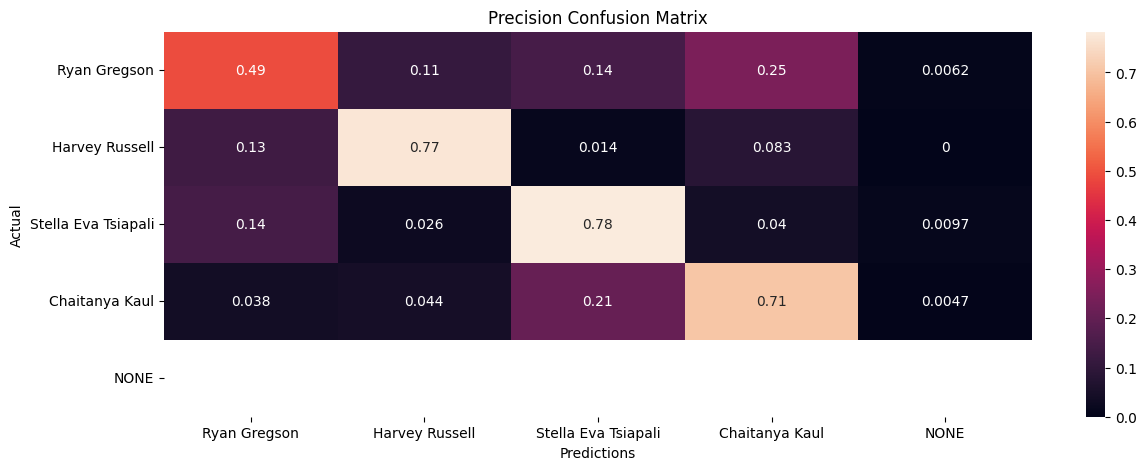

In [70]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subject_names = list(np.array(anon_names)[test_labels_s[:-1]])+["NONE"]

df_cm = pd.DataFrame(cfm_subject / np.sum(cfm_subject, axis=1)[:, None], index=subject_names, columns=subject_names)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')

C:\Users\jovin\AppData\Local\Temp\ipykernel_17028\1057855681.py:8: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cfm_liveness / np.sum(cfm_liveness, axis=1)[:, None], index=liveness_names, columns=liveness_names)


[Text(0.5, 25.722222222222214, 'Predictions'),
 Text(145.72222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

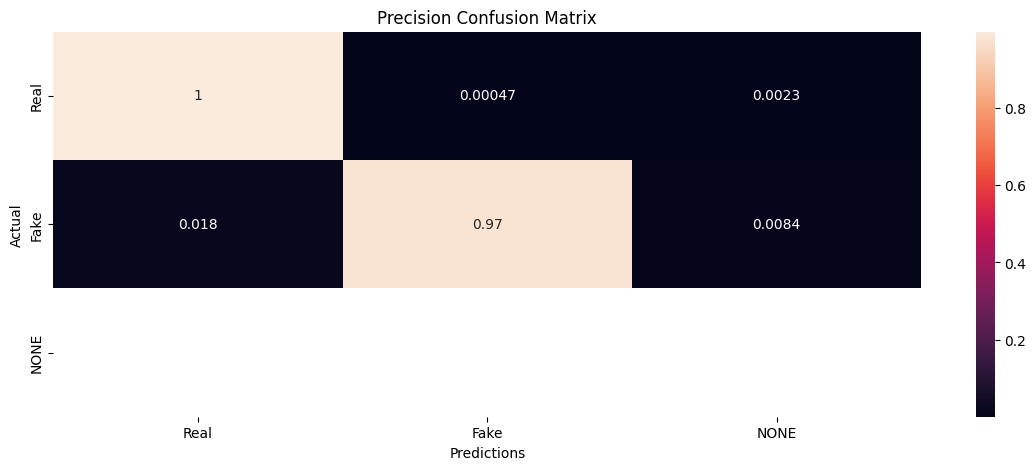

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

liveness_names = ["Real", "Fake", "NONE"]

# Build confusion matrix
df_cm = pd.DataFrame(cfm_liveness / np.sum(cfm_liveness, axis=1)[:, None], index=liveness_names, columns=liveness_names)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')

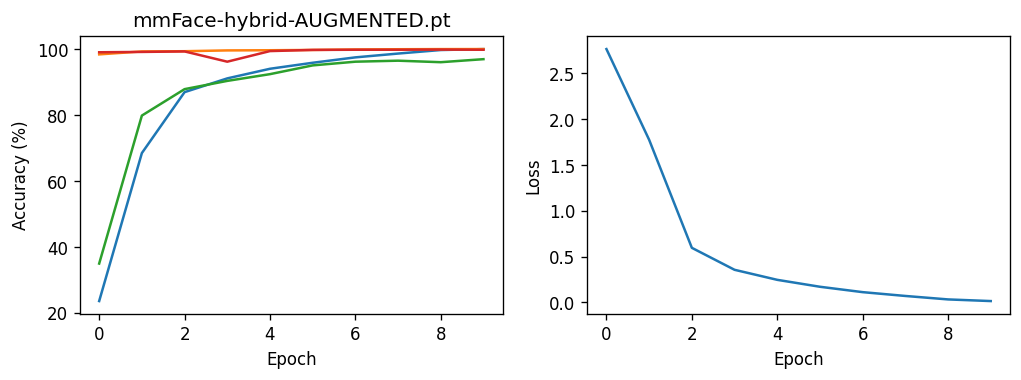

In [9]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(model_name)
plt.show()

### Subject Confusion Matrix

[Text(0.5, 25.222222222222214, 'Predictions'),
 Text(145.22222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

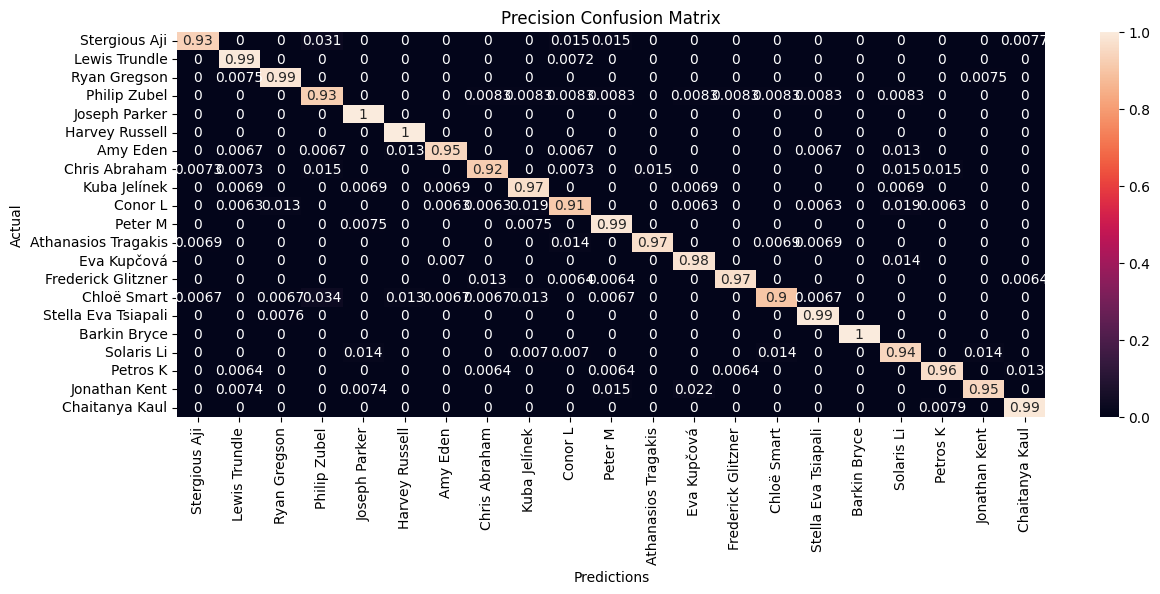

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subject_names = np.array(anon_names)

# Build confusion matrix
cf_matrix = confusion_matrix(preds_subject, true_subject)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subject_names, columns=subject_names)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')

### Liveness Confusion Matrix

[Text(0.5, 25.722222222222214, 'Predictions'),
 Text(145.72222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

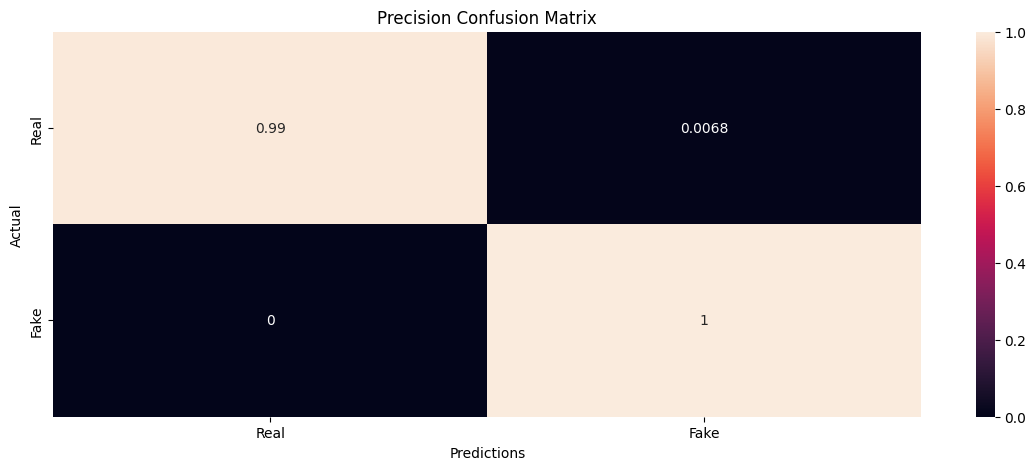

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Build confusion matrix
cf_matrix = confusion_matrix(preds_liveness, true_liveness)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=["Real", "Fake"], columns=["Real", "Fake"])
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')